In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def build_dataset(root, batch_size, download=False):
    train_dataset = datasets.FashionMNIST(
        root=root,                                
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]),
        download=download)
    test_dataset = datasets.FashionMNIST(
        root=root, 
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor()
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]),
        download=download)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, 
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=True)
    return train_dataset, test_dataset, train_loader, test_loader

train_dataset, test_dataset, train_loader, test_loader = build_dataset(root="./data/fashionmnist", batch_size=256, download=True)

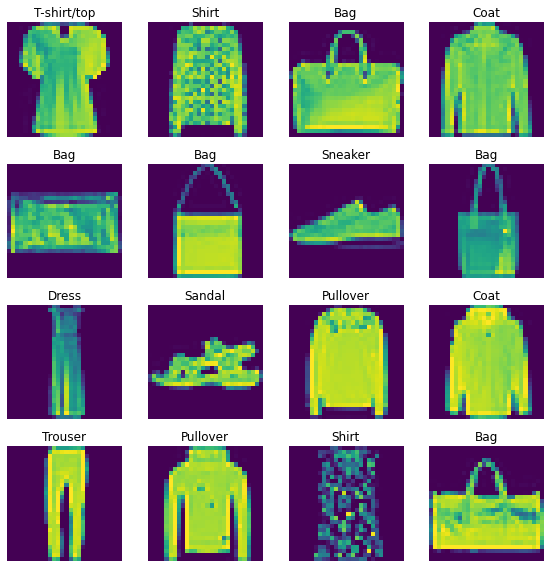

In [2]:
np.random.seed(78)
rand_idx = np.random.randint(low=0, high=len(train_dataset), size=(16,))
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, (data, label) in zip(axes.flatten(), [train_dataset[i] for i in rand_idx]):
    ax.imshow(data.squeeze().numpy())
    ax.set_title(f"{train_dataset.classes[label]}")
    ax.axis(False)
plt.tight_layout()
plt.show()

## Denosing Auto Encoder with CNN

In [3]:
class DenosingAutoEncoder(nn.Module):
    def __init__(self, noise_level):
        super(DenosingAutoEncoder, self).__init__()
        """CNN Denosing auto encoder"""
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5),  # (B, 1, 28, 28) > (B, 16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, return_indices=True),  # (B, 16, 24, 24) > (B, 16, 12, 12)
            nn.Conv2d(16, 32, 3),  # (B, 16, 12, 12) > (B, 32, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(2, return_indices=True)  # (B, 32, 10, 10) > (B, 32, 5, 5)
        )
        
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2), # (B, 32, 5, 5) > (B, 32, 10, 10)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),  # (B, 32, 10, 10) > (B, 16, 12, 12)
            nn.MaxUnpool2d(2), # (B, 16, 12, 12) > (B, 16, 24, 24)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 5),  # (B, 16, 24, 24) > (B, 1, 28, 28)
            nn.Sigmoid()
        )
        # add noise N(0, noise_level)
        self.noise_level = noise_level
        self.add_noise = lambda x: (torch.randn(x.size()) * self.noise_level).to(x.device) 
        
    def forward(self, x, add_noise=True):
        switches = defaultdict()
        if add_noise:
            x = x + self.add_noise(x)

        for i, layer in enumerate(self.encoder):
            if isinstance(layer, nn.MaxPool2d):
                x, switch = layer(x)
                switches[5-i] = switch  # save switch
            else:
                x = layer(x)
        
        for i, layer in enumerate(self.decoder):
            if isinstance(layer, nn.MaxUnpool2d):
                x = layer(x, switches[i])
            else:
                x = layer(x)
        return x

In [4]:
def train(model, train_loader, optimizer, loss_function, device):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, data)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss

def test(model, test_loader, loss_function, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += loss_function(output, data).item()
            
    return test_loss

def main_train(model, train_loader, test_loader, n_epoch, sv_path, filename, device):
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    best_loss = 99999
    
    for i, step in enumerate(range(n_epoch)):
        train_loss = train(model, train_loader, optimizer, loss_function, device)
        test_loss = test(model, test_loader, loss_function, device)
        
        if i % 5 == 0:
            print("----"*10)
            print(f"[Step] {step+1}/{n_epoch}")
            print(f"[Train] Average loss: {train_loss:.4f}")
            print(f"[Test] Average loss: {test_loss:.4f}")
            print("----"*10)
        if test_loss <= best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), sv_path / f"{filename}-best_model.pt")
            print(f"[Alert] best model saved at step: {step} - {test_loss:.4f}")
        
    print("[Traning is Done]")

In [11]:
torch.manual_seed(777)
torch.cuda.manual_seed(777)
n_epoch = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_level = 0.3

model = DenosingAutoEncoder(noise_level).to(device)
sv_path = Path(f"./states/state-dicts-autoencoder")
filename = "dae-cnn"

if not sv_path.exists():
    sv_path.mkdir()
main_train(model, train_loader, test_loader, n_epoch, sv_path, filename, device)

----------------------------------------
[Step] 1/20
[Train] Average loss: 16.0255
[Test] Average loss: 1.2661
----------------------------------------
[Alert] best model saved at step: 0 - 1.2661
[Alert] best model saved at step: 1 - 0.9709
[Alert] best model saved at step: 2 - 0.8496
[Alert] best model saved at step: 3 - 0.7794
[Alert] best model saved at step: 4 - 0.7256
----------------------------------------
[Step] 6/20
[Train] Average loss: 4.1093
[Test] Average loss: 0.6828
----------------------------------------
[Alert] best model saved at step: 5 - 0.6828
[Alert] best model saved at step: 6 - 0.6553
[Alert] best model saved at step: 7 - 0.6357
[Alert] best model saved at step: 8 - 0.6206
[Alert] best model saved at step: 9 - 0.6087
----------------------------------------
[Step] 11/20
[Train] Average loss: 3.5194
[Test] Average loss: 0.5937
----------------------------------------
[Alert] best model saved at step: 10 - 0.5937
[Alert] best model saved at step: 11 - 0.5860
[Al

In [12]:
torch.manual_seed(777)
batch = 4
for data, target in test_loader:
    choose = torch.randint(0, data.size(0), size=(batch,))
    data, target = data[choose], target[choose]
    break
    
def draw_samples(data, output, target, batch, noise_data=None):
    if noise_data is not None:
        fig, axes = plt.subplots(batch, 3, figsize=(8, 8))
        for i, row_axes in enumerate(axes):
            ax1, ax2, ax3 = row_axes
            ax1.imshow(data[i].squeeze())
            ax1.set_title(f"original: {target[i]}", fontsize=12)
            ax2.imshow(noise_data[i].squeeze())
            ax2.set_title(f"noised: {target[i]}", fontsize=12)
            ax3.imshow(output[i].squeeze())
            ax3.set_title(f"decoded: {target[i]}", fontsize=12)
            for ax in row_axes:
                ax.axis("off")
    else:
        fig, axes = plt.subplots(batch, 2, figsize=(8, 8))
        for i, row_axes in enumerate(axes):
            ax1, ax2 = row_axes
            ax1.imshow(data[i].squeeze())
            ax1.set_title(f"original: {target[i]}", fontsize=12)
            ax2.imshow(output[i].squeeze())
            ax2.set_title(f"decoded: {target[i]}", fontsize=12)
            for ax in row_axes:
                ax.axis("off")
    plt.tight_layout()
    plt.show()

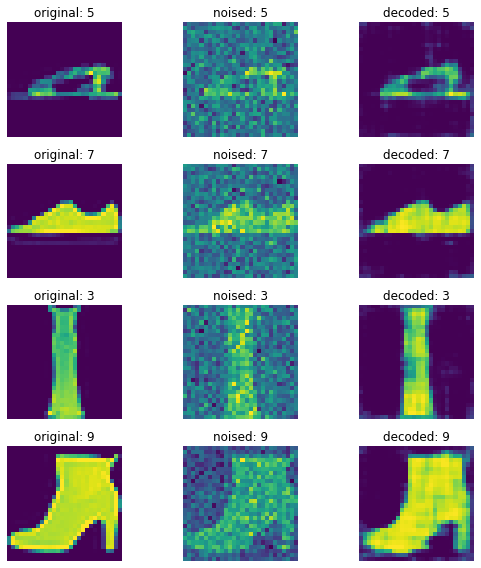

In [13]:
torch.manual_seed(777)
load_path = sv_path / f"{filename}-best_model.pt"

model = DenosingAutoEncoder(noise_level)
model.load_state_dict(torch.load(load_path, map_location="cpu"))
model.eval()
x = data.clone()
noised_x = x + model.add_noise(x)
# output = model(x, add_noise=True).detach()
output = model(noised_x, add_noise=False).detach()
draw_samples(data, output, target, batch, noised_x)

---

# Variational AutoEncoder

## Model

In [14]:
class VAE(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        
        self.last_h = 7
        self.last_w = 7
        self.last_channel = 64
        self.hidden_size = self.last_channel * self.last_h * self.last_w
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # (B, 1, 28, 28) > (B, 32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 28, 28) > (B, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, self.last_channel, kernel_size=4, stride=2, padding=1),  # (B, 32, 14, 14) > (B, 64, 7, 7)
            nn.Flatten()  # (B, self.hidden_size)
        )
        
        self.encoder2z = nn.Linear(self.hidden_size, 2*z_size)  # (B, self.hidden_size) > (B, 2*z_size)
        self.z2decoder = nn.Linear(z_size, self.hidden_size)  # (B, z_size) > (B, self.hidden_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.last_channel, 32, kernel_size=4, stride=2, padding=1),  # (B, 64, 20, 20) > (B, 32, 22, 22)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 22, 22) > (B, 16, 24, 24)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),  # (B, 8, 26, 26) > (B, 1, 28, 28)
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        """z = mu + e*sigma"""
        eps = torch.randn(mu.size()).to(mu.device)
        z = mu + torch.exp(log_var/2) * eps
        return z
    
    def encode(self, x):
        h = self.encoder(x)  # (B, 1, 28, 28) > (B, self.hidden_size)
        mu_std = self.encoder2z(h)  # (B, self.hidden_size) > (B, 2*z_size)
        return mu_std
    
    def decode(self, z):
        h = self.z2decoder(z)  # (B, z_size) > (B, self.hidden_size)
        h = h.view(z.size(0), self.last_channel, self.last_h, self.last_w)  # (B, self.hidden_size) > (B, 32, 7, 7)
        out = self.decoder(h)  # (B, 32, 7, 7) > (B, 1, 28, 28)
        return out
    
    def forward(self, x):
        mu_std = self.encode(x)  # (B, 1, 28, 28) > (B, 2*z_size)
        mu, log_var = torch.chunk(mu_std, 2, dim=1)  # (B, z_size), (B, z_size)
        z = self.reparameterize(mu, log_var)  # (B, z_size)
        out = self.decode(z)  # (B, z_size) > (B, 1, 28, 28)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decode(z)

## Loss Function

In [15]:
def KL_divergence(mu, log_var):
    """0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)"""
    return 0.5 * torch.sum((mu**2 + torch.exp(log_var) - log_var -1))

def loss_function(output, target, mu, log_var):
    bce = torch.nn.functional.binary_cross_entropy(output, target, reduction="sum")
    # (1) it's same as reconstruct loss (2) use it when the data range is not (0, 1)
    # mse = torch.nn.functional.mse_loss(output, target, reduction="mean")  
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld = KL_divergence(mu, log_var)
    return bce + kld

## Train Model

In [16]:
def train(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, mu, log_var = model(data)
        loss = loss_function(output, data, mu, log_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss / len(train_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output, mu, log_var = model(data)
            test_loss += loss_function(output, data, mu, log_var).item()
            
    return test_loss / len(test_loader.dataset)

def main_train(model, train_loader, test_loader, n_epoch, sv_path, filename, device):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    best_loss = 99999
    
    for i, step in enumerate(range(n_epoch)):
        
        train_loss = train(model, train_loader, optimizer, device)
        test_loss = test(model, test_loader, device)
        if i % 5 == 0:
            print("----"*10)
            print(f"[Step] {step+1}/{n_epoch}")
            print(f"[Train] Average loss: {train_loss:.4f}")
            print(f"[Test] Average loss: {test_loss:.4f}")
            print("----"*10)
            
        if (test_loss) <= best_loss:
            best_loss = (test_loss)
            torch.save(model.state_dict(), sv_path / f"{filename}-best_model.pt")
            print(f"[Alert] best model saved at step: {step} - {test_loss:.4f}")
        
    print("[Traning is Done]")

In [17]:
n_epoch = 30
device = "cuda" if torch.cuda.is_available() else "cpu"
z_size = 2

model = VAE(z_size).to(device)
sv_path = Path(f"./states/state-dicts-vae")
filename = "vae"
if not sv_path.exists():
    sv_path.mkdir()
main_train(model, train_loader, test_loader, n_epoch, sv_path, filename, device)

----------------------------------------
[Step] 1/30
[Train] Average loss: 309.8672
[Test] Average loss: 280.6218
----------------------------------------
[Alert] best model saved at step: 0 - 280.6218
[Alert] best model saved at step: 1 - 276.1708
[Alert] best model saved at step: 2 - 273.1988
[Alert] best model saved at step: 3 - 272.0821
[Alert] best model saved at step: 4 - 270.3490
----------------------------------------
[Step] 6/30
[Train] Average loss: 267.9222
[Test] Average loss: 269.7057
----------------------------------------
[Alert] best model saved at step: 5 - 269.7057
[Alert] best model saved at step: 6 - 269.3579
[Alert] best model saved at step: 7 - 268.6610
[Alert] best model saved at step: 8 - 268.6453
[Alert] best model saved at step: 9 - 268.0251
----------------------------------------
[Step] 11/30
[Train] Average loss: 265.3722
[Test] Average loss: 267.2405
----------------------------------------
[Alert] best model saved at step: 10 - 267.2405
[Alert] best mod

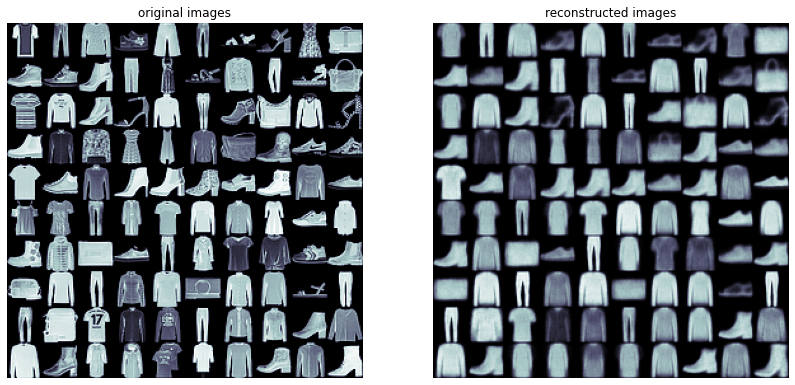

In [18]:
def create_figure(x, n=10):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    counter = 0
    for i in range(n):
        for j in range(n):
            digit = x[counter].squeeze().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            counter += 1
    return figure

# Load Model
torch.manual_seed(777)
load_path = sv_path / f"{filename}-best_model.pt"
model = VAE(z_size)
model.load_state_dict(torch.load(load_path, map_location="cpu"))
model.eval()

# Create Images baesd on input images
images, labels = next(iter(test_loader))
img_fig = create_figure(images)
recon, *_ = model(images)
recon_fig = create_figure((recon * 255).byte().detach()) #.view(-1, 28, 28))

fig, axes = plt.subplots(1, 2, figsize=(14, 18))
titles = ["original images", "reconstructed images"]
figs = [img_fig, recon_fig]
for ax, title, f in zip(axes, titles, figs):
    ax.imshow(f, cmap="bone")
    ax.axis("off")
    ax.set_title(title)
plt.show()

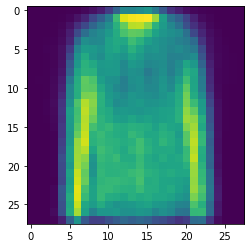

In [19]:
z = torch.randn(1, 2)
image = model.sample(z).detach().squeeze()
plt.imshow(image)
plt.show()

## 2 Latent Factor Visualization

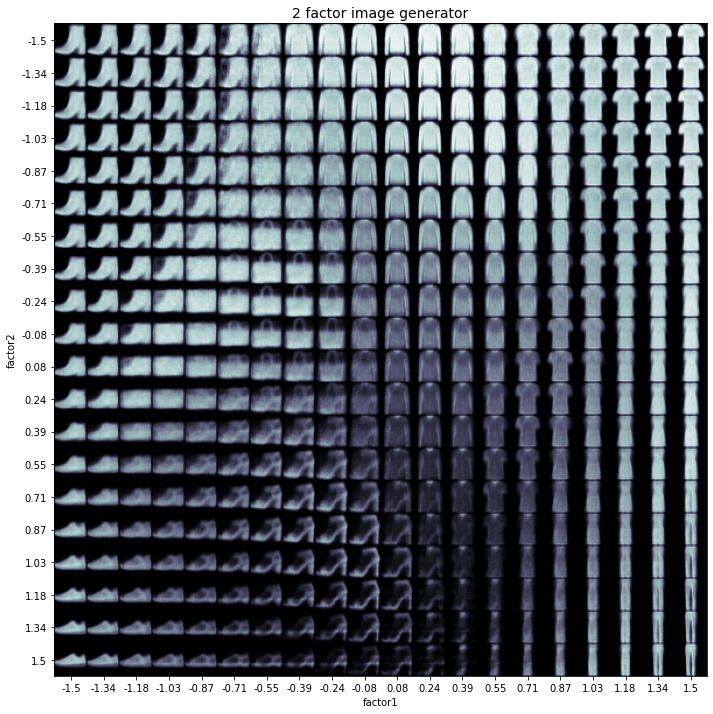

In [35]:
n = 20
zz = np.linspace(-1.5, 1.5, n)
z1, z2 = np.meshgrid(zz, zz, indexing='ij')
Z = np.dstack([z1, z2])
images = []
for i in range(n):
    for j in range(n):
        z = torch.FloatTensor(Z[i, j]).unsqueeze(0)
        image = model.sample(z).detach()
        images.append(image)
images = torch.stack(images)
images_fig = create_figure(images, n=n)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_title("2 factor image generator", fontsize=14)
ax.set_xlabel("factor1")
ax.set_ylabel("factor2")
ax.set_xticks([28*i + 14 for i in range(n)])
ax.set_yticks([28*i + 14 for i in range(n)])
ax.set_xticklabels(zz.round(2))
ax.set_yticklabels(zz.round(2))
ax.imshow(images_fig, cmap="bone")
ax.axis()
plt.show()